In [1]:
! pip install torch torchvision

In [2]:
# import packages
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
import numpy as np
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
# load dataset, only the first 100000
def convert_to_numpy(dataloader):
    data, labels = [], []
    for images, lbls in dataloader:
        data.append(images.view(images.size(0), -1).numpy())
        labels.append(lbls.numpy())
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

def prepare_corpus(trainset:torchvision.datasets, testset:torchvision.datasets):
    """
    return standard scaled X and Y datasets
    """
    # select only part of the dataset (for efficiency)
    train_indices = list(range(10000)) 
    test_indices = list(range(2000))  
    # take subset
    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    batch_size = 4
    subset_trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    subset_testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    # for loading full training and testing dataset
    # full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    # full_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    X_train, y_train = convert_to_numpy(subset_trainloader)
    X_test, y_test = convert_to_numpy(subset_testloader)

    # X_full_train, y_full_train = convert_to_numpy(full_trainloader)
    # X_full_test, y_full_test = convert_to_numpy(full_testloader)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # X_full_train = scaler.fit_transform(X_full_train)
    # X_full_test = scaler.transform(X_full_test)

    return X_train, y_train, X_test, y_test


In [4]:
# Find best hyperparameter

In [5]:
def errors_for_train_sizes(clf, train_sizes, X_tr, y_tr, X_te, y_te):
    tr_err = [] 
    te_err = [] 

    for i in train_sizes:
        clf.fit(X_tr[:i], y_tr[:i])

        y_pred_tr = clf.predict(X_tr[:i])
        tr_err.append(1 - accuracy_score(y_tr[:i], y_pred_tr))

        y_pred_te = clf.predict(X_te)
        te_err.append(1 - accuracy_score(y_te, y_pred_te))

    return tr_err, te_err

def plot_errors_for_train_sizes(train_sizes, tr_err, te_err):
    plt.semilogx(train_sizes, tr_err, label='Train', marker='x', linestyle='-', color='blue')
    plt.semilogx(train_sizes, te_err, label='Test', marker='x', linestyle='--', color='blue')

    plt.xlabel('Number of Training Data Points')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title('Error rate vs training data points')
    plt.show()

def reportLearningCurve(clf, train_sizes, X_train, y_train, X_test, y_test):
    tr_err, te_err = errors_for_train_sizes(clf, train_sizes, X_train, y_train, X_test, y_test)
    plot_errors_for_train_sizes(train_sizes, tr_err, te_err)


In [6]:
def reportConfusionMatrix(clf, title:str, X_test, y_test):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.title(title)
    plt.show()

In [7]:
def reportPredictionTime(clf, X_test):
    start_time = time.time()
    predictions = clf.predict(X_test)
    end_time = time.time()

    prediction_time = end_time - start_time
    time_per_image = prediction_time / len(X_test)
    print(f"Average prediction time per image: {time_per_image:.6f} seconds")

In [8]:
# prepare corpus
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
                                        
X_train, y_train, X_test, y_test = prepare_corpus(full_trainset, full_testset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
find best hyper-parameter
clf:RandomForestClassifier = RandomForestClassifier(n_estimators=50,
                                                    criterion = 'gini',
                                                    min_samples_split = 2,
                                                    min_samples_leaf = 1,
                                                    )
parameters = {
    "n_estimators" : [5,25,50,100],
    "min_samples_split" : [2,5,10],
    "min_samples_leaf" : [2,5,10]
}
record = dict()
for x in parameters["n_estimators"]:
    for y in parameters["min_samples_split"]:
        for z in parameters["min_samples_leaf"]:
            print(x,y,z, sep="      ")
            clf:RandomForestClassifier = RandomForestClassifier(n_estimators=x,
                                                    criterion = 'gini',
                                                    min_samples_split = y,
                                                    min_samples_leaf = z,
                                                    )
            clf.fit(X_train, y_train)
            acc = accuracy_score(y_test, clf.predict(X_test))
            record[acc] = record.get(acc, []) +[(x,y,z)]
            print("Accuracy: ", acc)

best_acc = max(record.keys())
best_model = record[best_acc]
print("Best model: ", best_model, "Accuracy_score: ", best_acc )


In [10]:
# set up best clf
clf:RandomForestClassifier = RandomForestClassifier(n_estimators=100,
                                                    criterion = 'gini',
                                                    min_samples_split = 5,
                                                    min_samples_leaf = 5,
                                                    )

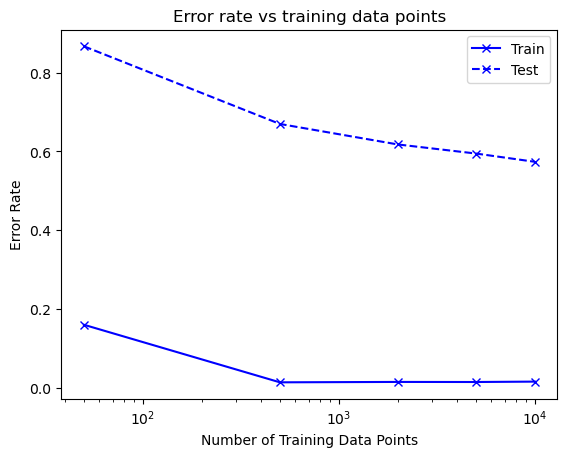

In [11]:
# report learning curve
train_sizes = [50, 500, 2000, 5000, 10000]
reportLearningCurve(clf, train_sizes, X_train, y_train, X_test, y_test)

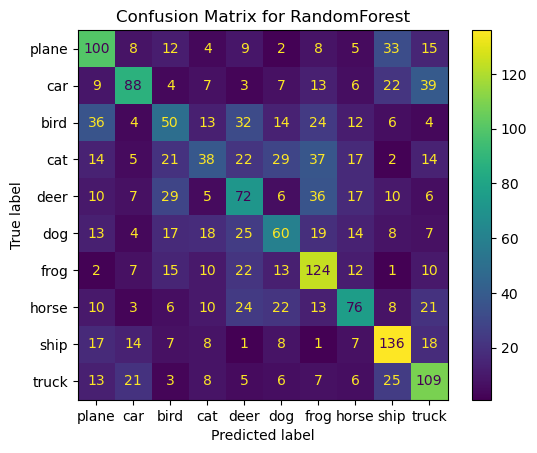

In [12]:
# report Confusion matrix
reportConfusionMatrix(clf, title="Confusion Matrix for RandomForest", X_test=X_test, y_test = y_test)

In [13]:
# report Prediction speed
reportPredictionTime(clf, X_test=X_test)

Average prediction time per image: 0.000032 seconds
